### ArXiv Metadata Analysis
#### Capstone Project, DSI-911 cohort, Lisa Paul

**Current Notebook:** 01-preprocess-EDA
>Run this Second to read-in testing & training CSV data, then encode pred-column, add features (columns)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')  # For word tokenization
nltk.download('stopwords')  # For stopwords removal



[nltk_data] Downloading package punkt to /Users/lisapaul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisapaul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
img_path = '../images/'

data_path = '../data/'

orig_df = pd.read_csv(data_path + "arxiv_meta_aa-single-cat.csv")

In [4]:
orig_df.head(1)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,NaN,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."


In [5]:
#training file has only 32031 records (because of previous cleaning)
orig_df.shape

(32031, 14)

In [6]:
#function to encode the categories (research fields)
def encode_cats(df):
    # Make a copy of the DataFrame to avoid modifying the original data
    encoded_df = df.copy()
    
    # which column to encode? confusingly: "categories"
    categorical_column = encoded_df['categories']

    #Instance the encoder
    le = LabelEncoder()

    # Encode 'categories' column
    encoded_df['numeric_categories'] = le.fit_transform(categorical_column)
    
    return encoded_df


In [7]:
#Call this function exactly once (per df) to create df w/ one extra column
#Cleaner code would be to call this //within// the feature-adding function
encoded_df = encode_cats(orig_df)

encoded_df.columns

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed', 'numeric_categories'],
      dtype='object')

In [8]:
encoded_df.shape
#correctly has 1 extra column now

(32031, 15)

In [9]:
print ("Unique CategoryNames:\t", 
        len(encoded_df['categories'].unique()),  
       "\nUnique CategoryNums:\t", 
       len(encoded_df['numeric_categories'].unique())
      )

Unique CategoryNames:	 120 
Unique CategoryNums:	 120


#### Function to drop the columns I don't want.

In [10]:
def drop_cols(df):
    
    cols_to_keep = ['id', 'title', 'abstract', 'categories', 'numeric_categories'
]
    smaller_df = df[cols_to_keep]
    
    return smaller_df

In [11]:
smaller_df = drop_cols(encoded_df)
smaller_df.shape

(32031, 5)

In [12]:
#I'm going to use this and skip all that feature eng for now

#### The **add_text_features** function will add some new features (based on NLP of the abstract).
> I used chatGPT to suggest solutions to type errors

> These features will almost all be ignored for the preliminary model.


In [13]:

def add_text_features(df):
    
    featured_df = df.copy()
    
    #Create new column containing list of the words in the abstract (for each row)
    abs_tokens = featured_df['abstract'].apply(word_tokenize)
    featured_df['abs_tokens'] = abs_tokens

    # Create new column containing abstract wordlist _without_ stopwords
    # apply stopword removal across all rows
    abs_no_sw = abs_tokens.apply(lambda tokens: [token for token in tokens if token.lower() not in stopwords.words('english')])
    featured_df['abs_tokens_no_sw'] = abs_no_sw
    
    
    # Most additional features are based on previous stopword removal: 
    
    # Create new column for the count of unique words
    unique_wc = abs_no_sw.apply(tuple).nunique()
    featured_df['unique_wc'] = unique_wc

    # Create new column for the total word count
    wc = abs_no_sw.apply(len).sum()
    featured_df['wc'] = wc

    # Create new column for the ratio of unique wc to total wc
    unique_words_ratio = unique_wc / wc
    featured_df['unique_words_ratio'] = unique_words_ratio


    return featured_df

#### More thoughts about add_text_features():

#### Another less-interpretable approach  would be to do Vectorizing, instead of creating all these data manually.
#####     TF-IDF would be better than CountVectorizer because:
> - considers the context of the entire dataframe, and penalizes common words across rows
> - thus "ignoring" the noisy ones that aren't useful for classifying
        
##### Assuming, however, that I manually created more features, here are a few that could be interesting or useful:
> Create new columns for 1 or 2 parts of speech (e.g., noun, adjective)
>   - nltk.pos_tag() 

> Or, features which require original abstract, not tokenized:
>   - Create a new column for counting special characters
>   - Add a column for general char_count
>   - Same for readability scores such as Flesch-Kincaid or SMOG




For the expanded study/analysis, we want to use 2 separate csv chunks of the original dataset
For the preliminary study, after slow performance processing 2 dataframes, coupled with extremely large files that caused GitHub warnings
I decided to go with Train Test Split method after all, which only needs 1 dataframe here.

In [14]:
%%time 
#call on only 1 dataframe, because more  is out of scope for "prelim study"
featured_df = add_text_features(smaller_df)


CPU times: user 8min 14s, sys: 1min 58s, total: 10min 13s
Wall time: 12min 35s


In [15]:
featured_df.shape

(32031, 10)

In [16]:
featured_df.columns

Index(['id', 'title', 'abstract', 'categories', 'numeric_categories',
       'abs_tokens', 'abs_tokens_no_sw', 'unique_wc', 'wc',
       'unique_words_ratio'],
      dtype='object')

In [17]:
featured_df['abs_tokens_no_sw']

0        [fully, differential, calculation, perturbativ...
1        [evolution, Earth-Moon, system, described, dar...
2        [show, determinant, Stirling, cycle, numbers, ...
3        [study, two-particle, wave, function, paired, ...
4        [rather, non-standard, quantum, representation...
                               ...                        
32026    [assumption, matter, charges, currents, could,...
32027    [low-temperature, behavior, Casimir-Polder, fr...
32028    [shown, steady, state, probability, distributi...
32029    [vector, $, r=, (, r_1, ,, ..., ,, r_n, ), $, ...
32030    [study, corrections, due, two, Pomeron, exchan...
Name: abs_tokens_no_sw, Length: 32031, dtype: object

In [18]:
#Save enhanced dataframes to a csv file:
#currently 96.38 MB
featured_df.to_csv(data_path + "featured.csv", index=False)


#### Those look great, but I need to scale back for prelim model

#### Next, EDA!


Let's see which, if any features will be useful to use for prediction modelling:

Q: Do a **correlations heatmap**, to find what goes with preds (cats)?
 
> A: not yet, because I have string data in there!
(If I wanted to, I would start by dropping columns, to create a numeric-only dataframe)


In [19]:
#Unrelatedly, I'm going to remove the extra numeric features, to simplify code and modeling
columns_to_remove = ['unique_wc', 'wc', 'unique_words_ratio']
tokened_df = featured_df.drop(columns=columns_to_remove)


In [23]:
def top_ten(column):
    ten_top_cats = column.value_counts().head(10)
    return ten_top_cats

top_num_cats = top_ten(tokened_df['numeric_categories'])
top_str_cats = top_ten(tokened_df['categories'])
print(top_str_cats)

categories
astro-ph             8529
hep-ph               2697
quant-ph             2165
hep-th               1871
cond-mat.mtrl-sci    1050
gr-qc                1000
cond-mat.mes-hall     872
nucl-th               725
hep-ex                723
cond-mat.str-el       717
Name: count, dtype: int64


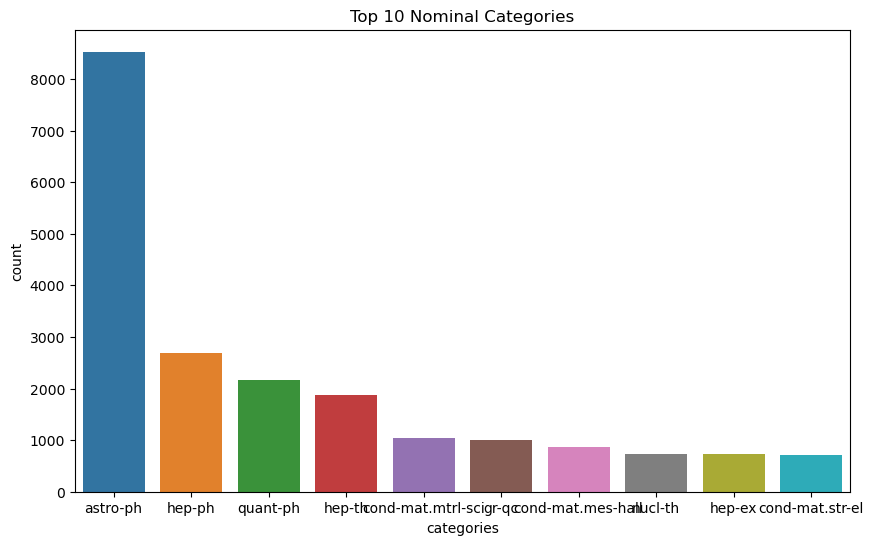

In [30]:

# Plot the top categories
plt.figure(figsize=(10, 6))
sns.countplot(x='categories', data=tokened_df, order=top_str_cats.index)
plt.title('Top 10 Nominal Categories')
plt.savefig(img_path+'top_categories_plot.png', dpi=300)
plt.show()


#### This is pretty imbalanced! 



#### Next, let's get ready to do some modeling!

In [31]:
#premodel (including pre-TTS) processing

#scaling back, prelim model, etc.
cols_to_remove = ['categories', 'numeric_categories', 'title', 'abs_tokens', 'abs_tokens_no_sw', 'id']

# Separate features (X) and target variable (y)
X = tokened_df.drop(cols_to_remove, axis=1)
y = tokened_df['numeric_categories']


X['abstract'] = X['abstract'].str.lower()
X.head(1)


,abstract
0,a fully differential calculation in perturba...


In [32]:
y.head(1)

0    46
Name: numeric_categories, dtype: int64

#### Due to severe imbalance, let's remove rows in uncommon categories!


In [34]:
#This cell uses some chatGPT syntax for expediency

# Set a threshold for the minimum number of samples per class
threshold = 10

# Count the occurrences of each class
class_counts = pd.Series(y).value_counts()

# Filter classes that meet the threshold
valid_classes = class_counts[class_counts >= threshold].index

# Filter the data and labels based on valid classes
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

# Print the updated shapes
print("Original Shapes:", X.shape, y.shape)
print("Filtered Shapes:", X_filtered.shape, y_filtered.shape)


Original Shapes: (32031, 1) (32031,)
Filtered Shapes: (31963, 1) (31963,)


In [ ]:
#### Due to errors, this will follow closely on lesson 505, NLP 2:

In [35]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

In [36]:
y_test.value_counts(normalize = True)


numeric_categories
0      0.260490
46     0.081419
115    0.072927
47     0.060440
43     0.031344
         ...   
32     0.000125
104    0.000125
38     0.000125
20     0.000125
33     0.000125
Name: proportion, Length: 116, dtype: float64

In [39]:
# Instantiate (w/ Stop Words)
cvec = CountVectorizer(stop_words = 'english')


# Fit the vectorizer on our corpus.
cvec.fit(X_train)

# Transform the corpus.
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)


AttributeError: 'csr_matrix' object has no attribute 'lower'

In [ ]:
X_train.shape

In [ ]:
type(X_train)

In [ ]:
X_train.todense()


In [ ]:
#copy more of lesson 505 in here if I want to try
#but this may not work for the turnin prelims